# Prévision de série temporelle pour le jeu de cartes Magic

On souhaite analyser le prix de vente d'une carte Magic, au cours du temps.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import json
plt.rcParams["figure.figsize"] = (20,10)

## Chargement des prix au format .json

GoatBots est une chaîne de bots qui enregistre au format JSON l'historique de prix des cartes sur MTGO (Magic Online).  
Voici une fonction pour récupérer cet historique sous forme de Dataframe, pour une certaine carte:

In [4]:
def prices_goat(card):
    r = requests.get("https://www.goatbots.com/card/ajax_card?search_name=" + card)
    all_prices = r.json()[1] # r.json()[0] est un header qui ne nous intéresse pas
    prices = all_prices[1] # prix d'une édition de card
    d = pd.DataFrame(prices, columns = ["Date", "Sell Price"])
    d['Date'] = pd.to_datetime(d['Date'])
    d = d.set_index('Date')
    return d

<AxesSubplot:xlabel='Date'>

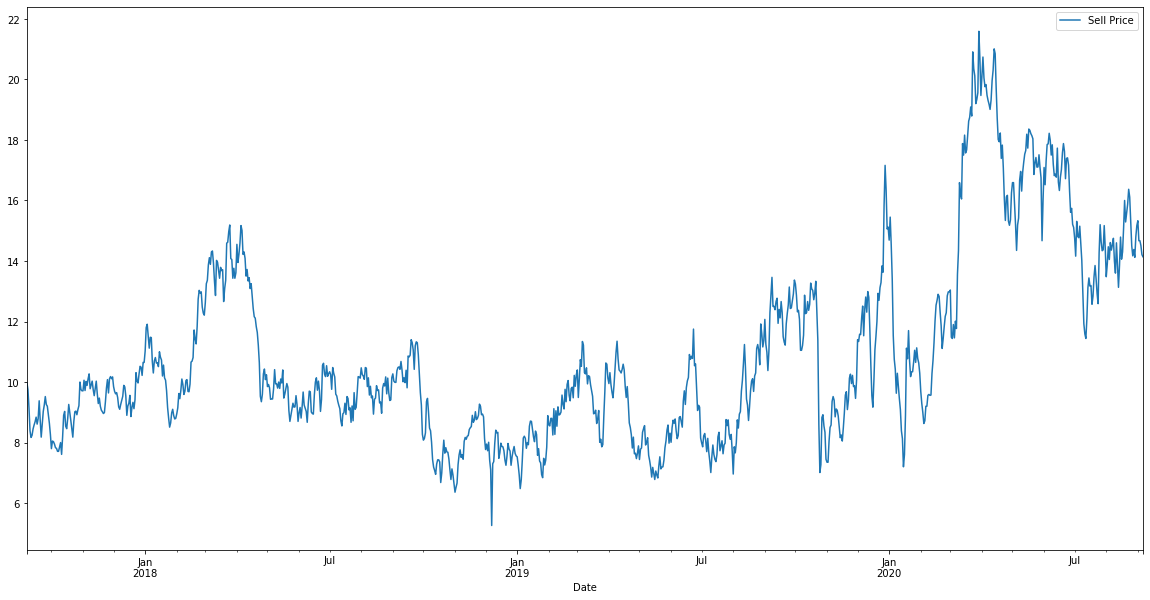

In [22]:
prices = prices_goat("misty-rainforest") # regardons l'historique de la carte Misty Rainforest
prices.plot()

## Analyse

Pour éliminer la partie "tendance" de la courbe, on peut regarder les différences entre t+1 et t:

<AxesSubplot:xlabel='Date'>

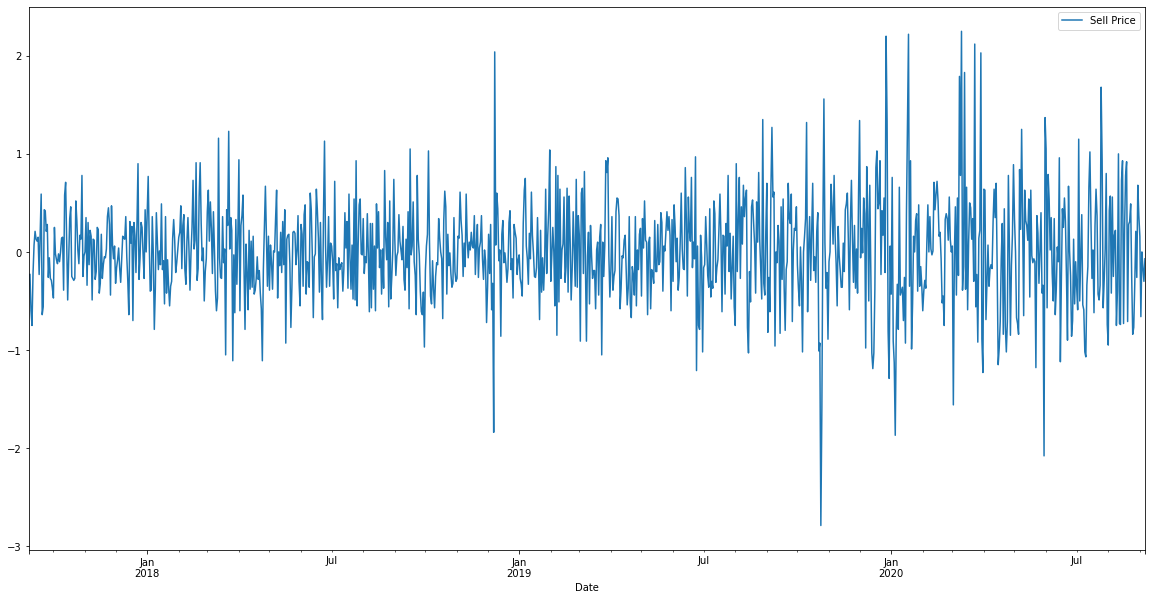

In [23]:
prices.diff(periods=1).plot() # variations journalières

Pour lisser la courbe, on peut utiliser un EMA (Exponential Moving Average):

<AxesSubplot:xlabel='Date'>

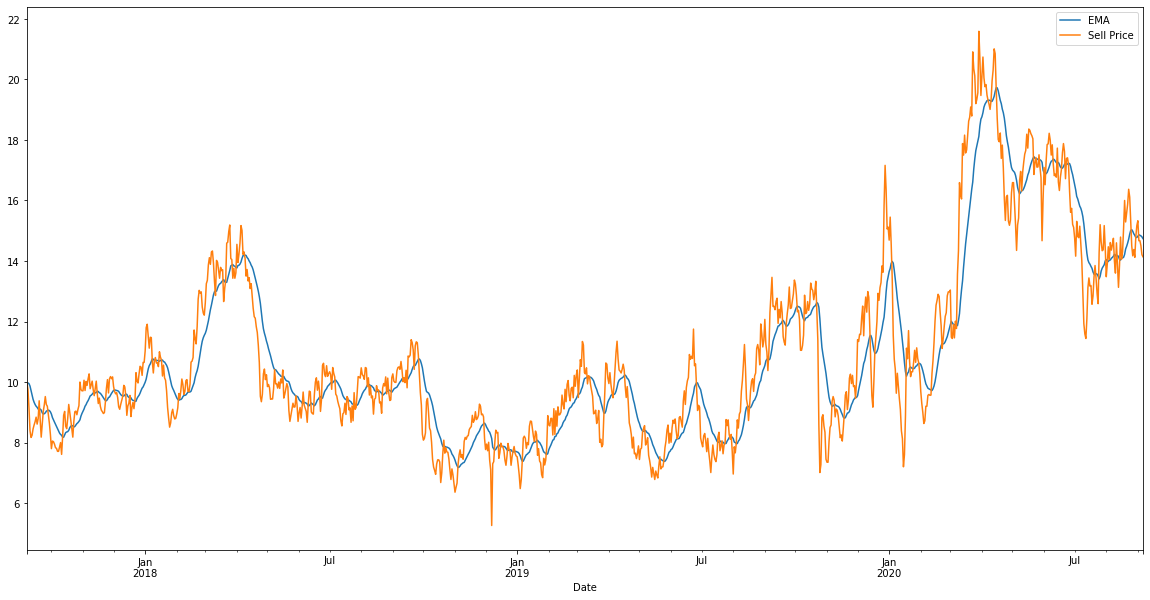

In [24]:
def exp_mov_avg(d, a):
    ema = d.copy()
    for i in range(1, len(d)):
        ema.iloc[i] = a * d.iloc[i - 1] + (1 - a) * ema.iloc[i - 1]
    return ema
ema = exp_mov_avg(prices, 0.1)
plot_ema = ema.rename(columns = {"Sell Price": "EMA"}).plot()
prices.plot(ax=plot_ema)

## Prédictions

Essayons d'effectuer une prédiction sur 10 jours.
La méthode naïve consisterait à prédire le prix à l'instant t+10 en utilisant le prix à l'instant t:

In [25]:
prices["Sell Price"].diff(5).abs().mean()

0.8610357470210815

Cette méthode naïve donne une MAE (Mean Absolute Error) de 1.112 environ.

0.9850722525939402

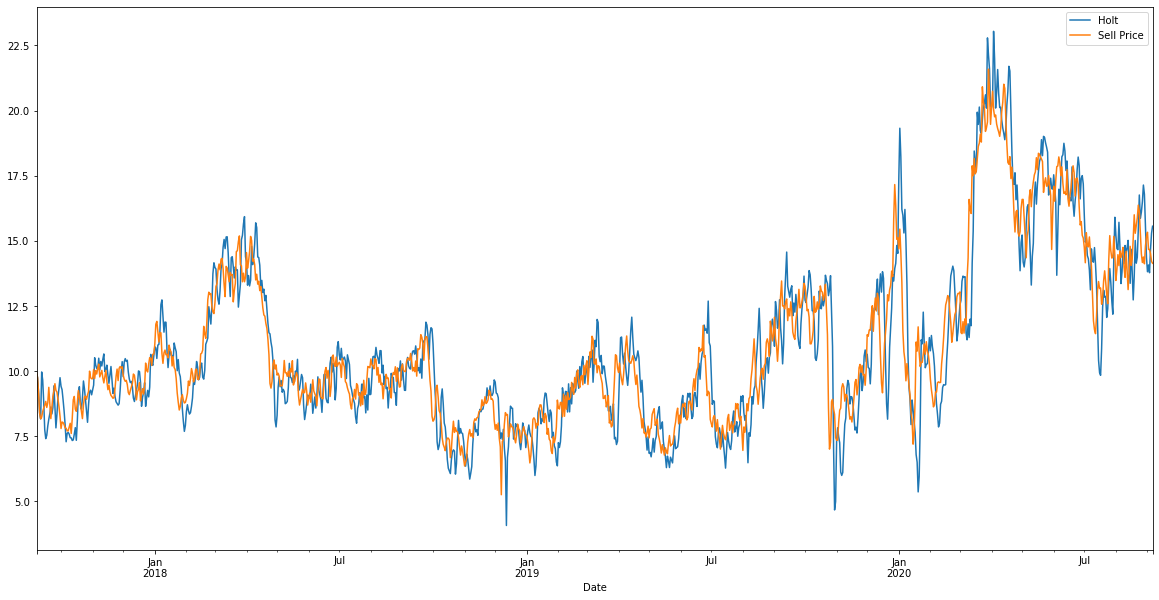

In [26]:
def holt(d, a, b, forecast):
    pred_next = d.copy()
    pred = d.copy()
    trend = d.copy()
    trend.iloc[0] = 0
    for i in range(1, len(d)):
        if i >= forecast:
            pred_next.iloc[i] = pred.iloc[i-forecast] + forecast*trend.iloc[i-forecast]
        pred.iloc[i] = a*d.iloc[i] + (1 - a)*(pred.iloc[i-1] + trend.iloc[i - 1])
        trend.iloc[i] = b*(pred.iloc[i] - pred.iloc[i - 1]) + (1 - b)*trend.iloc[i - 1]
    return pred_next, pred, trend
p, pred, trend = holt(prices, 0.9, 0.1, 5)
axe = p.rename(columns = {"Sell Price": "Holt"}).plot()
prices.plot(ax=axe)
(prices["Sell Price"] - p["Sell Price"]).abs().mean()

In [28]:
def best_params_holt(d, forecast):
    mini = 1000
    amin, bmin = 0, 0
    for a in np.arange(0.5, 1, 0.1):
        for b in np.arange(0, 0.3, 0.1):
            pred_next, pred, trend = holt(d, a, b, forecast)
            mae = (prices["Sell Price"] - pred_next["Sell Price"]).abs().mean()
            if mae < mini:
                mini, amin, bmin = mae, a, b
    return mini, amin, bmin
best_params_holt(prices, 5)

(0.8551671077390227, 0.7999999999999999, 0.0)

<AxesSubplot:xlabel='Date'>

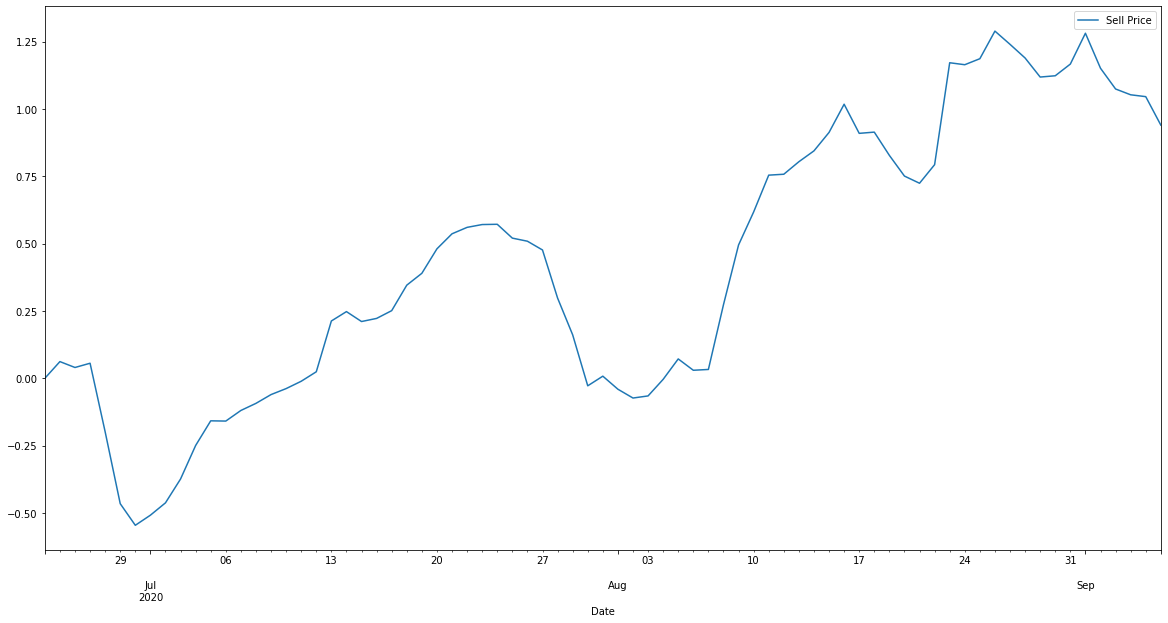

In [579]:
trend.plot()

# Prophet

In [591]:
from fbprophet import Prophet
m = Prophet()
d = pd.DataFrame({"ds": prices.index, "y": prices["Sell Price"]})
m.fit(d)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [592]:
future = m.make_future_dataframe(periods=0, freq="D")
future.tail()

,ds
33,2020-09-02
34,2020-09-03
35,2020-09-04
36,2020-09-05
37,2020-09-06


In [594]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-07-31,21.484662,20.593852,22.089067,21.484662,21.484662,-0.170419,-0.170419,-0.170419,-0.170419,-0.170419,-0.170419,0.0,0.0,0.0,21.314243
1,2020-08-01,21.700565,20.877137,22.425705,21.700565,21.700565,-0.056268,-0.056268,-0.056268,-0.056268,-0.056268,-0.056268,0.0,0.0,0.0,21.644297
2,2020-08-02,21.916468,21.191317,22.668476,21.916468,21.916468,0.012928,0.012928,0.012928,0.012928,0.012928,0.012928,0.0,0.0,0.0,21.929397
3,2020-08-03,22.132372,21.218937,22.818789,22.132372,22.132372,-0.126411,-0.126411,-0.126411,-0.126411,-0.126411,-0.126411,0.0,0.0,0.0,22.005961
4,2020-08-04,22.348275,21.970707,23.495638,22.348275,22.348275,0.384484,0.384484,0.384484,0.384484,0.384484,0.384484,0.0,0.0,0.0,22.732759
5,2020-08-05,22.564178,21.853411,23.378286,22.564178,22.564178,0.059388,0.059388,0.059388,0.059388,0.059388,0.059388,0.0,0.0,0.0,22.623566
6,2020-08-06,22.780081,21.908876,23.440594,22.780081,22.780081,-0.103703,-0.103703,-0.103703,-0.103703,-0.103703,-0.103703,0.0,0.0,0.0,22.676379
7,2020-08-07,22.995985,22.080064,23.596380,22.995985,22.995985,-0.170419,-0.170419,-0.170419,-0.170419,-0.170419,-0.170419,0.0,0.0,0.0,22.825566
8,2020-08-08,23.211888,22.429439,23.917047,23.211888,23.211888,-0.056268,-0.056268,-0.056268,-0.056268,-0.056268,-0.056268,0.0,0.0,0.0,23.155619
9,2020-08-09,23.427791,22.691608,24.212801,23.427791,23.427791,0.012928,0.012928,0.012928,0.012928,0.012928,0.012928,0.0,0.0,0.0,23.440719


In [584]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, horizon="10 days")

INFO:fbprophet:Making 7 forecasts with cutoffs between 2020-07-28 00:00:00 and 2020-08-27 00:00:00


In [600]:
df_cv.head()
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-07-29,16.122748,12.441469,19.513636,15.13,2020-07-28
1,2020-07-30,16.506944,12.986639,19.838611,13.34,2020-07-28
2,2020-07-31,16.801163,13.505908,20.132177,13.92,2020-07-28
3,2020-08-01,17.333387,13.683713,20.662572,13.35,2020-07-28
4,2020-08-02,17.207555,13.643170,20.873937,13.00,2020-07-28
...,...,...,...,...,...,...
65,2020-09-02,44.941238,41.285363,48.239303,48.45,2020-08-27
66,2020-09-03,45.536723,42.179252,48.714980,48.89,2020-08-27
67,2020-09-04,46.043895,42.853017,49.317523,49.81,2020-08-27
68,2020-09-05,47.399876,43.945240,50.690219,50.81,2020-08-27


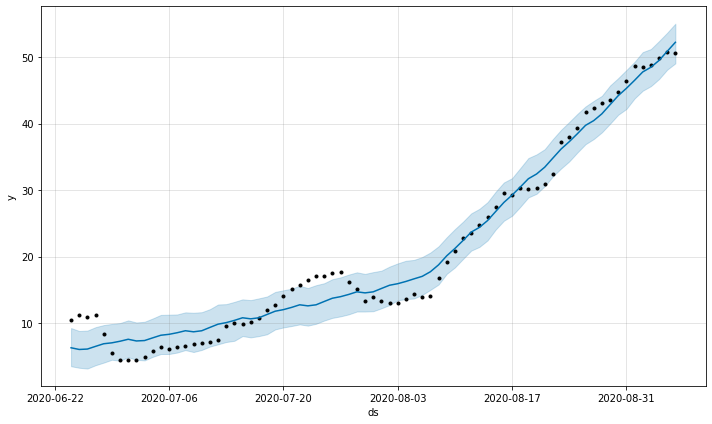

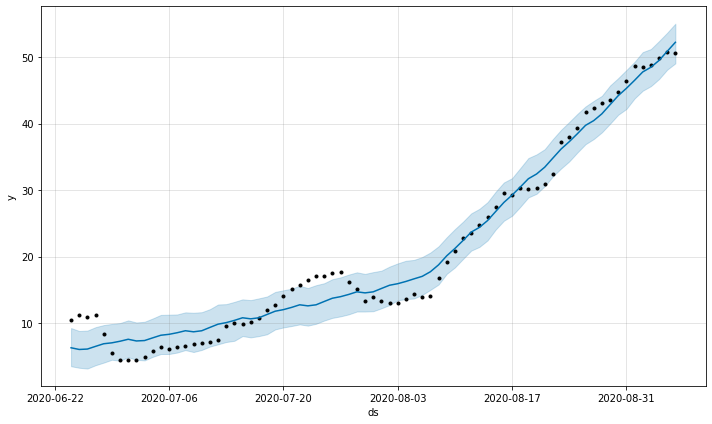

In [587]:
m.plot(forecast)

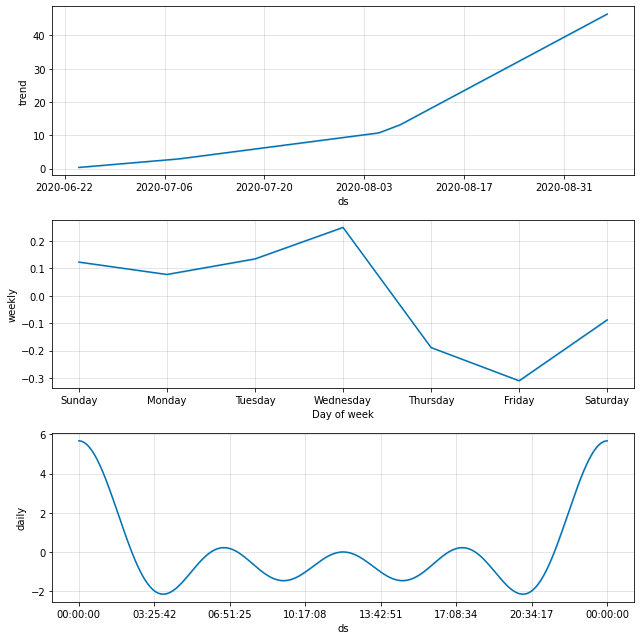

In [588]:
fig2 = m.plot_components(forecast)